In [3]:
from transformers import pipeline # importing hugging face
from nltk import sent_tokenize # sentence tokenizer, separate text to multiple sentences
import nltk
import torch
from glob import glob # for file paths
import pandas as pd # for tabular dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\alvee\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alvee\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### (1) LOAD THEME-CLASSIFIER MODEL

In [5]:
model_name = "facebook/bart-large-mnli"
device = 0 if torch.cuda.is_available() else 'cpu' # if gpu present use gpu, 0 is gpu number 1
# check if gpu or cpu. we get 0 so gpu
print (f"gpu->0 else 'cpu', we get : {device}")

gpu->0 else 'cpu', we get : 0


In [6]:
# LOAD THE THEME-CLASSIFIER MODEL 
# but its not recommended to read model_name from global variable, this fucntion should be inside a class

def load_model(device):
    theme_classifier = pipeline(
        "zero-shot-classification",
        model=model_name,
        device=device
    )
    return theme_classifier


In [7]:
theme_classifier = load_model(device) # install the model in puts it into gpu-mem?
# should unload it as well after work done? search how to unload


C:\Users\alvee\AppData\Roaming\Python\Python310\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
theme_list = ["friendship", "hope", "sacrifice", "battle", "self development", "betrayal", "love", "dialogue", "fear"]
# friendship, hope, sacrifice, battle, self development, betrayal, love, dialogue

In [12]:
# to classify anything with the zero-shot classifier just call it
# write any text and run it, it gives probability score for each class
theme_classifier(
    "It was a cold dark night in the graveyard, when i heard noises down the isle and something was singing in a scary voice ",
    theme_list, 
    multi_labels=True
)




{'sequence': 'It was a cold dark night in the graveyard, when i heard noises down the isle and something was singing in a scary voice ',
 'labels': ['fear',
  'dialogue',
  'self development',
  'sacrifice',
  'betrayal',
  'battle',
  'friendship',
  'love',
  'hope'],
 'scores': [0.6471216678619385,
  0.11516249179840088,
  0.07549849897623062,
  0.06328720599412918,
  0.04112415760755539,
  0.02909783460199833,
  0.013085508719086647,
  0.009307315573096275,
  0.006315321195870638]}

### (2) LOAD DATASET

In [10]:
# load subtitles dataset
files = glob('../data/Subtitles/*.ass') # * means get all file with .ass 
files[:5] # test , print first 5 

['../data/Subtitles\\Naruto Season 1 - 01.ass',
 '../data/Subtitles\\Naruto Season 1 - 02.ass',
 '../data/Subtitles\\Naruto Season 1 - 03.ass',
 '../data/Subtitles\\Naruto Season 1 - 04.ass',
 '../data/Subtitles\\Naruto Season 1 - 05.ass']

In [11]:
with open(files[0], 'r') as file:
    lines = file.readlines()
    
    # data cleaning
    lines = lines[27:] # data from line 27, because before it are meta data
    lines = [",".join(line.split(',')[9:]) for line in lines ]# remove everything before the 9th comma , we just want the text
    lines = [line.replace('\\N',' ') for line in lines ]# remove \\n from the text


#  check 
lines[:2]

['A long time ago, a powerful demon fox appeared with nine tails.\n',
 'With its powerful tails,\n']

In [12]:
# combine different sentences into one-big paragraph
" ".join(lines[:10]) # joins first 10 lines
# this is the paragraph to be fed in theme-clf FNN, it can ake max 512 tokens input
# so divide it in batches [:10] / [:20] etc

"A long time ago, a powerful demon fox appeared with nine tails.\n With its powerful tails,\n it could smash mountains and create tidal waves.\n A band of Ninjas rose to defend their village from attack.\n We have to wait until the Fourth Hokage gets here!\n We can't let it get any closer to our village!\n One great Ninja was able to imprison the monster,\n but died in the process.\n This Ninja was known asâ€¦ the Fourth Hokage.\n Naruto!\n"

In [13]:
# extract episode number from subitle file name


In [48]:
# put all above from (2) Load Dataset in a single function : 
def load_subtitles_dataset(dataset_path):
    subtitles_paths = glob(dataset_path + '/*.ass')
    scripts = []
    episode_num = []
    for path in subtitles_paths: #path is the directory/file.ass
        # print(f"debug path: {path}")
        # from each path/ subtitle file read lines
        with open(path, 'r', encoding='utf-8') as file: # without  encoding='utf-8' gives error, not shown in video
            lines = file.readlines()
            
            # data/line cleaning
            lines = lines[27:] # data from line 27, because before it are meta data
            lines = [",".join(line.split(',')[9:]) for line in lines ]# remove everything before the 9th comma , we just want the text
        
        # data/line cleaning
        lines = [line.replace('\\N',' ') for line in lines ]# remove \\n from the text
        script = " ".join(lines) # all texts to one big paragraph

        episode = int(path.split('-')[-1].split('.')[0].strip())
        scripts.append(script)
        episode_num.append(episode)

    df = pd.DataFrame.from_dict({"episode" : episode_num, "script": scripts})
    return df



In [49]:
dataset_path = "../data/Subtitles" 
df = load_subtitles_dataset(dataset_path)

df.head()
    

,episode,script
0,1,"A long time ago, a powerful demon fox appeared..."
1,2,"C'mon!\n Running like a fugitive,\n Being chas..."
2,3,"C'mon!\n Running like a fugitive,\n Being chas..."
3,4,"C'mon!\n Running like a fugitive,\n Being chas..."
4,5,"C'mon!\n Running like a fugitive,\n Being chas..."


(2.1) RUN MODEL

In [50]:
# load 'script' of the first episode [0]
script = df.iloc[0]['script']

# print script
script # one long script

# divide sciprt for tokenizer
script_sentences = sent_tokenize(script)

# print
script_sentences[:3] # display first 3 sentences

['A long time ago, a powerful demon fox appeared with nine tails.',
 'With its powerful tails,\n it could smash mountains and create tidal waves.',
 'A band of Ninjas rose to defend their village from attack.']

In [51]:
# batch sentences
sentence_batch_size = 20
script_batches = []
for index in range(0, len(script_sentences), sentence_batch_size): # each indx jump by setence_batch_size which is 20
    sent = " ".join(script_sentences[index:index + sentence_batch_size])
    script_batches.append(sent)

# 20 sentences batched together 
script_batches[:2] # each 20 sentence is 1 batch, so [:2] display first 2 batch meaning 40 sentences

["A long time ago, a powerful demon fox appeared with nine tails. With its powerful tails,\n it could smash mountains and create tidal waves. A band of Ninjas rose to defend their village from attack. We have to wait until the Fourth Hokage gets here! We can't let it get any closer to our village! One great Ninja was able to imprison the monster,\n but died in the process. This Ninja was known as… the Fourth Hokage. Naruto! Why did you do such a thing?! You're really gonna get it this time! I don't care! You know your problem? You can't do the things I do! Only I can do this! I'm better than all of you! Believe it! There's a problem, sir! Lord Hokage! What is it? Did that Naruto do something again?",
 'Yes. He climbed onto the Mountainside Images…\n And he vandalized and graffitied all over them! Wait! Ha ha…\n Why should I? Hey, Naruto! How did you suddenly get here, lruka Sensei? The question is what are you doing here when you should be in class now? Now listen, Naruto. You failed t

In [52]:
# put subtitle data into model : 
theme_output = theme_classifier(
    script_batches[:3],
    theme_list,
    multi_label=True
)

In [53]:
# output 
theme_output

# structured Output ==> battle :[batch_1_score,batch_2_score, ...] ==> battle : [0.3232,0.5645,..]
themes = {}
for output in theme_output:
    for label,score in zip(output['labels'],output['scores']):
        if label not in themes:
            themes[label] = []
        themes[label].append(score)

# print strcutured theme outputs for each batches
themes

{'dialogue': [0.980073869228363, 0.9370123147964478, 0.9554799199104309],
 'betrayal': [0.9396897554397583, 0.6457234621047974, 0.7342314124107361],
 'battle': [0.854687511920929, 0.6581311225891113, 0.752046525478363],
 'sacrifice': [0.7349810004234314, 0.6258835792541504, 0.5151650905609131],
 'self development': [0.7284947037696838,
  0.8678191304206848,
  0.7187488079071045],
 'hope': [0.19909749925136566, 0.20424073934555054, 0.5138543844223022],
 'friendship': [0.05922317877411842, 0.0860324501991272, 0.3491222560405731],
 'love': [0.040261927992105484, 0.02802046574652195, 0.19979596138000488]}

In [55]:
# put all above code from (2.1) run model in below function:
def get_theme_inference(script):
    script_sentences = sent_tokenize(script)
    
    # Batch sentences
    # batch sentences
    sentence_batch_size = 20
    script_batches = []
    for index in range(0, len(script_sentences), sentence_batch_size):
        sent = " ".join(script_sentences[index:index + sentence_batch_size])
        script_batches.append(sent)

    # Run model
    theme_output = theme_classifier(
        script_batches[:2],
        theme_list,
        multi_label=True
    )
    
    # structured/wrangle Output
    themes = {}
    for output in theme_output:
        for label,score in zip(output['labels'],output['scores']):
            if label not in themes:
                themes[label] = []
            themes[label].append(score)

    # Find mean of each theme, (batch_1_score + batch_2_score + batch_n_score) / n
    themes = {key : np.mean(value) for key,value in themes.items()}
    
    # each score below for each theme is a mean of all scores of that theme    
    return themes

In [56]:

df = df # whole dataset / all epiodes
# df = df.head(2)
df

# Run for every episode's script, only 2 episodes as df = df.head(2)
output_themes = df['script'].apply(get_theme_inference) # runs get_theme_inference() func for all episode's script

# we running on gpu so its fast, 
# see task_manager to see gpu usegase go up while running this code cell
# WE RUN THE WHOLE DATASET ON THEME_CLASSIFIER using OUR GPU


In [57]:
# output
output_themes # for all episodes
print(f"For all episodes : \n{output_themes}")

# just analyze one episode
print(f"\nAnalyze single episode:")# here for each episode (0 to 217) we get mean score of each theme in a dict per episode
output_themes[0]

For all episodes : 
0      {'dialogue': 0.9585430920124054, 'betrayal': 0...
1      {'dialogue': 0.9606055617332458, 'sacrifice': ...
2      {'dialogue': 0.9430063962936401, 'sacrifice': ...
3      {'dialogue': 0.7951260209083557, 'sacrifice': ...
4      {'dialogue': 0.9142743051052094, 'betrayal': 0...
                             ...                        
213    {'dialogue': 0.8980685174465179, 'betrayal': 0...
214    {'dialogue': 0.9584203064441681, 'friendship':...
215    {'dialogue': 0.9379824995994568, 'sacrifice': ...
216    {'sacrifice': 0.889953076839447, 'dialogue': 0...
217    {'dialogue': 0.9236288666725159, 'battle': 0.8...
Name: script, Length: 218, dtype: object

Analyze single episode:


{'dialogue': 0.9585430920124054,
 'betrayal': 0.7927066087722778,
 'battle': 0.7564093172550201,
 'sacrifice': 0.6804322898387909,
 'self development': 0.7981569170951843,
 'hope': 0.2016691192984581,
 'friendship': 0.07262781448662281,
 'love': 0.03414119686931372}

In [58]:
theme_df = pd.DataFrame(output_themes.tolist())

theme_df

,dialogue,betrayal,battle,sacrifice,self development,hope,friendship,love
0,0.958543,0.792707,0.756409,0.680432,0.798157,0.201669,0.072628,0.034141
1,0.960606,0.429944,0.684844,0.570702,0.482807,0.154534,0.046261,0.173261
2,0.943006,0.339491,0.707885,0.661516,0.724140,0.573633,0.342217,0.394863
3,0.795126,0.554723,0.723674,0.652153,0.861327,0.445293,0.525341,0.315333
4,0.914274,0.891102,0.783642,0.585847,0.550454,0.093763,0.073856,0.054070
...,...,...,...,...,...,...,...,...
213,0.898069,0.797842,0.254797,0.746412,0.605169,0.067470,0.413257,0.179151
214,0.958420,0.445381,0.775835,0.830450,0.594065,0.334442,0.681656,0.491752
215,0.937982,0.503365,0.915607,0.853974,0.605135,0.175045,0.299854,0.260860
216,0.877789,0.596258,0.838390,0.889953,0.691779,0.403402,0.823457,0.458263


In [59]:
df[theme_df.columns] = theme_df
df

,episode,script,dialogue,betrayal,battle,sacrifice,self development,hope,friendship,love
0,1,"A long time ago, a powerful demon fox appeared...",0.958543,0.792707,0.756409,0.680432,0.798157,0.201669,0.072628,0.034141
1,2,"C'mon!\n Running like a fugitive,\n Being chas...",0.960606,0.429944,0.684844,0.570702,0.482807,0.154534,0.046261,0.173261
2,3,"C'mon!\n Running like a fugitive,\n Being chas...",0.943006,0.339491,0.707885,0.661516,0.724140,0.573633,0.342217,0.394863
3,4,"C'mon!\n Running like a fugitive,\n Being chas...",0.795126,0.554723,0.723674,0.652153,0.861327,0.445293,0.525341,0.315333
4,5,"C'mon!\n Running like a fugitive,\n Being chas...",0.914274,0.891102,0.783642,0.585847,0.550454,0.093763,0.073856,0.054070
...,...,...,...,...,...,...,...,...,...,...
213,216,"Summoning Jutsu!\n Oh, long time no see.\n We ...",0.898069,0.797842,0.254797,0.746412,0.605169,0.067470,0.413257,0.179151
214,217,Gaara.\n Kankuro.\n Gaara.\n Primary Lotus!\n ...,0.958420,0.445381,0.775835,0.830450,0.594065,0.334442,0.681656,0.491752
215,218,To think the Leaf’s reinforcements will be you...,0.937982,0.503365,0.915607,0.853974,0.605135,0.175045,0.299854,0.260860
216,219,"Fly into the wavy and twisted sky, into your h...",0.877789,0.596258,0.838390,0.889953,0.691779,0.403402,0.823457,0.458263


# VISUALIZE OUTPUT

In [ ]:
# dropping dialogue as it can be any convo
df = df.drop('dialogue',axis=1)

In [ ]:
# dont need episode and script 
theme_output = df.drop(['episode','script'],axis=1).sum().reset_index()
# WHAT WE NEED : 
theme_output.columns = ['theme', 'score']
theme_output

,theme,score
0,betrayal,125.939202
1,battle,160.191156
2,sacrifice,174.533173
3,self development,158.880458
4,hope,93.879776
5,friendship,82.097135
6,love,54.508286


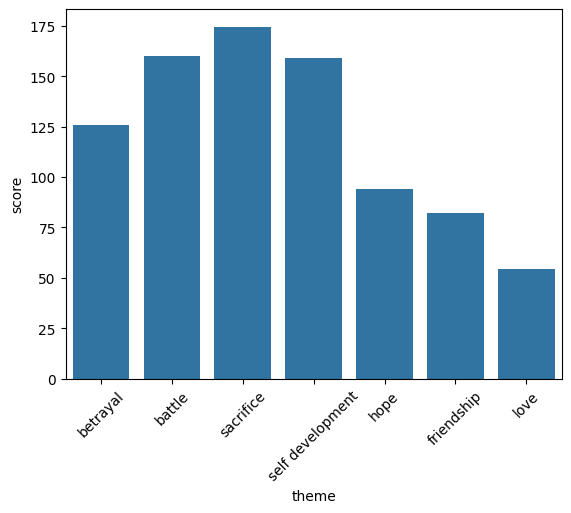

In [67]:
# convert to visualiation
sns.barplot(data=theme_output, x="theme", y="score")
plt.xticks(rotation=45)
plt.show()